<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/VAE_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# VAE 4
# https://spaces.ac.cn/archives/5887

# mimicing
# https://github.com/bojone/vae/blob/master/vae_keras_cluster.py

# created by
# https://gemini.google.com/app/64f9247342835580


Using device: cpu
Starting training...
Epoch 1/50, Loss: 56.5785
Epoch 2/50, Loss: 44.9978
Epoch 3/50, Loss: 43.8118
Epoch 4/50, Loss: 43.1163
Epoch 5/50, Loss: 42.6250
Epoch 6/50, Loss: 42.3200
Epoch 7/50, Loss: 42.0678
Epoch 8/50, Loss: 41.7940
Epoch 9/50, Loss: 41.6249
Epoch 10/50, Loss: 41.4875
Epoch 11/50, Loss: 41.2872
Epoch 12/50, Loss: 41.1884
Epoch 13/50, Loss: 41.0678
Epoch 14/50, Loss: 40.9520
Epoch 15/50, Loss: 40.8893
Epoch 16/50, Loss: 40.7466
Epoch 17/50, Loss: 40.7541
Epoch 18/50, Loss: 40.6258
Epoch 19/50, Loss: 40.5753
Epoch 20/50, Loss: 40.4856
Epoch 21/50, Loss: 40.4618
Epoch 22/50, Loss: 40.4124
Epoch 23/50, Loss: 40.3333
Epoch 24/50, Loss: 40.3285
Epoch 25/50, Loss: 40.2733
Epoch 26/50, Loss: 40.2368
Epoch 27/50, Loss: 40.2115
Epoch 28/50, Loss: 40.2123
Epoch 29/50, Loss: 40.0914
Epoch 30/50, Loss: 40.1066
Epoch 31/50, Loss: 40.0268
Epoch 32/50, Loss: 40.0395
Epoch 33/50, Loss: 39.9857
Epoch 34/50, Loss: 39.9759
Epoch 35/50, Loss: 39.9330
Epoch 36/50, Loss: 39.917

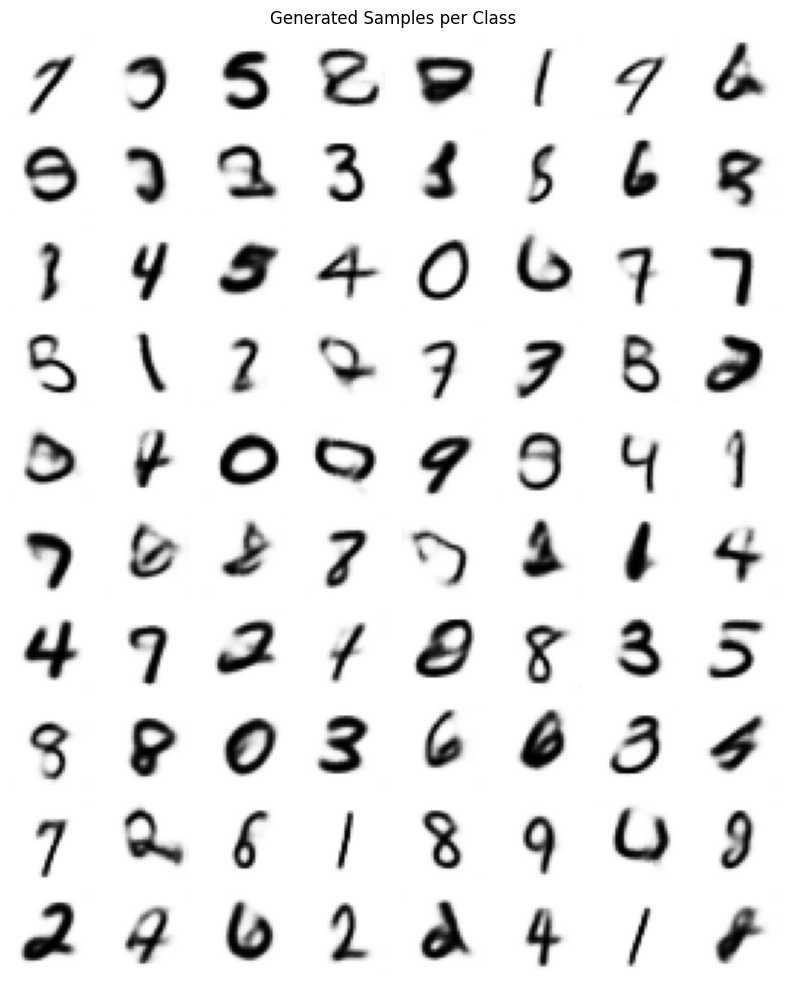

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Hyperparameters ---
BATCH_SIZE = 100
LATENT_DIM = 20
EPOCHS = 50
NUM_CLASSES = 10
IMG_DIM = 28
FILTERS = 16
INTERMEDIATE_DIM = 256
LAMBDA = 2.5 # Weight for reconstruction loss

# --- 1. Data Loading and Preprocessing ---
def load_mnist_data(batch_size=100):
    """
    Loads and preprocesses the MNIST dataset using PyTorch's DataLoader.
    """
    transform = transforms.Compose([
        transforms.ToTensor(), # Converts to tensor and scales to [0, 1]
    ])

    # Check if data directory exists, create if not
    data_dir = './data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# --- 2. VAE Model Components ---

class Encoder(nn.Module):
    """
    The Encoder network, which maps an input image to the latent space
    by outputting a mean (z_mean) and log-variance (z_log_var) vector.
    """
    def __init__(self, latent_dim=20):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim

        # The final feature map dimensions after the conv layers are 7x7
        # and the number of channels is FILTERS*4 (16*4=64).
        self.h_shape = (FILTERS * 4, 7, 7)
        self.h_prod = np.prod(self.h_shape)

        self.conv_layers = nn.Sequential(
            # Block 1: Input (1, 28, 28) -> Output (32, 14, 14)
            nn.Conv2d(1, FILTERS*2, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(FILTERS*2, FILTERS*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            # Block 2: Input (32, 14, 14) -> Output (64, 7, 7)
            nn.Conv2d(FILTERS*2, FILTERS*4, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(FILTERS*4, FILTERS*4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )

        self.fc_mean = nn.Linear(self.h_prod, self.latent_dim)
        self.fc_log_var = nn.Linear(self.h_prod, self.latent_dim)

    def forward(self, x):
        h = self.conv_layers(x)
        h = h.view(h.size(0), -1) # Flatten
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)
        return z_mean, z_log_var

class Decoder(nn.Module):
    """
    The Decoder network, which reconstructs an image from a latent vector z.
    """
    def __init__(self, latent_dim=20):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        # The starting feature map shape for the decoder is the final shape of the encoder.
        self.h_shape = (FILTERS * 4, 7, 7) # Should be (64, 7, 7)
        self.h_prod = np.prod(self.h_shape)

        self.dense = nn.Linear(self.latent_dim, self.h_prod)

        self.deconv_layers = nn.Sequential(
            # Block 1: Input (64, 7, 7) -> Output (32, 14, 14)
            nn.ConvTranspose2d(FILTERS*4, FILTERS*4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(FILTERS*4, FILTERS*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),

            # Block 2: Input (32, 14, 14) -> Output (16, 28, 28)
            nn.ConvTranspose2d(FILTERS*2, FILTERS*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(FILTERS*2, FILTERS, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),

            # Final layer for reconstruction: Input (16, 28, 28) -> Output (1, 28, 28)
            nn.ConvTranspose2d(FILTERS, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(), # Output activation for pixel values in [0, 1]
        )

    def forward(self, z):
        h = self.dense(z)
        h = h.view(h.size(0), *self.h_shape) # Reshape
        x_recon = self.deconv_layers(h)
        return x_recon

class Classifier(nn.Module):
    """
    A simple classifier that predicts the digit class from the latent vector z.
    """
    def __init__(self, latent_dim=20, num_classes=10):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, INTERMEDIATE_DIM),
            nn.ReLU(),
            nn.Linear(INTERMEDIATE_DIM, num_classes),
            nn.Softmax(dim=1) # Softmax activation for class probabilities
        )

    def forward(self, z):
        return self.net(z)

class GaussianPrior(nn.Module):
    """
    A custom layer to represent the means of the conditional Gaussian prior p(z|y).
    This layer holds a learnable mean vector for each class.
    """
    def __init__(self, num_classes=10, latent_dim=20):
        super(GaussianPrior, self).__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        # `mean` is a learnable parameter of shape (num_classes, latent_dim)
        self.mean = nn.Parameter(torch.zeros(num_classes, latent_dim))

    def forward(self, z, y_pred):
        # z: (batch_size, latent_dim)
        # y_pred: (batch_size, num_classes)
        # Use y_pred to get a weighted sum of prior means for each sample
        z_prior_mean = torch.matmul(y_pred.unsqueeze(1), self.mean.unsqueeze(0))
        z_prior_mean = z_prior_mean.squeeze(1) # Squeeze to shape (batch_size, latent_dim)
        return z_prior_mean


class VAE(nn.Module):
    """
    The main VAE model, combining the Encoder, Decoder, Classifier,
    and a Gaussian Prior layer.
    """
    def __init__(self, latent_dim=20, num_classes=10):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.classifier = Classifier(latent_dim, num_classes)
        self.gaussian_prior = GaussianPrior(num_classes, latent_dim)

    def reparameterize(self, z_mean, z_log_var):
        """Reparameterization trick to sample z from the latent distribution."""
        std = torch.exp(0.5 * z_log_var)
        epsilon = torch.randn_like(std)
        return z_mean + std * epsilon

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_recon = self.decoder(z)
        y = self.classifier(z)
        z_prior_mean = self.gaussian_prior(z, y)

        return x_recon, z_mean, z_log_var, z_prior_mean, y, z

# --- 3. Custom Loss Function ---
def vae_loss_function(x, x_recon, z_mean, z_log_var, z_prior_mean, y):
    """
    Custom VAE loss function as described in the Keras code.
    It combines reconstruction loss, KL divergence, and a categorical loss term.
    """
    # Reconstruction Loss (Mean Squared Error)
    xent_loss = 0.5 * F.mse_loss(x, x_recon, reduction='none').sum(dim=[1, 2, 3])

    # KL Divergence Loss
    # KL(q(z|x) || p(z|y)) = 0.5 * sum(var + (mean - prior_mean)^2 - log(var) - 1)
    kl_loss = -0.5 * torch.sum(z_log_var - torch.square(z_mean - z_prior_mean) - torch.exp(z_log_var), dim=1)

    # Categorical Loss (Negative Entropy)
    # The Keras code uses K.mean(y * K.log(y + K.epsilon()), 0), which is negative entropy.
    # This term encourages the classifier output to be 'flat' (high entropy),
    # which is a common technique in unsupervised clustering with VAEs.
    cat_loss = -torch.sum(y * torch.log(y + 1e-8), dim=1)

    # Total VAE loss
    total_loss = (LAMBDA * xent_loss + kl_loss + cat_loss).mean()
    return total_loss

# --- 4. Training and Evaluation ---
def train(model, train_loader, optimizer, device, epochs):
    """
    Training loop for the VAE model.
    """
    model.train()
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            x_recon, z_mean, z_log_var, z_prior_mean, y, _ = model(data)
            loss = vae_loss_function(data, x_recon, z_mean, z_log_var, z_prior_mean, y)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')
    print("Training finished.")

def generate_samples(model, means, std=1.0, device='cpu', num_samples_per_class=8, img_dim=28):
    """
    Generates samples conditioned on the learned class means.
    """
    model.eval()
    all_images = []

    with torch.no_grad():
        for i in range(NUM_CLASSES):
            # Sample from the Gaussian prior for the current class
            noise = torch.randn(num_samples_per_class, LATENT_DIM).to(device) * std
            z_sample = noise + means[i]

            # Decode the latent vector to an image
            x_recon = model.decoder(z_sample).cpu()
            all_images.append(x_recon)

    all_images = torch.cat(all_images, dim=0)

    # Visualize the generated images
    fig = plt.figure(figsize=(num_samples_per_class, NUM_CLASSES))
    grid_size_h = num_samples_per_class
    grid_size_w = NUM_CLASSES

    for i in range(NUM_CLASSES * num_samples_per_class):
        ax = fig.add_subplot(grid_size_w, grid_size_h, i + 1)
        ax.imshow(all_images[i].squeeze().numpy(), cmap='gray_r')
        ax.axis('off')

    plt.suptitle('Generated Samples per Class')
    plt.tight_layout()
    plt.show()

# --- Main execution block ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_loader, test_loader = load_mnist_data(BATCH_SIZE)

    model = VAE(LATENT_DIM, NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(model, train_loader, optimizer, device, EPOCHS)

    # After training, get the learned means from the Gaussian Prior layer
    learned_means = model.gaussian_prior.mean.detach().cpu()

    # Generate and visualize samples for each class
    generate_samples(model, learned_means, device=device)
